In [1]:
# MGMTMFE 431 - Quantitative Asset Management
# Problem Set 4
# Akhil Srivastava

# Downloads and saves CRSP raw data
def download_raw_crsp_data(data_dir, wrds_id):
    ###################################### Download CRSP stock data ######################################
    
    # Download CRSP stock monthly returns
    # Reference - Assignment Instruction:
    # "This should be the full dataset available on WRDS; do not pre-filter by SHRCD, EXCHCD, or date."
    conn = wrds.Connection(wrds_username=wrds_id)
    mscrsp_raw = conn.raw_sql("""select a.permno, a.permco, a.date, b.shrcd, b.exchcd, b.siccd, b.naics,
                                a.ret, a.retx, a.shrout, a.prc
                                from crspq.msf as a
                                left join crspq.msenames as b
                                on a.permno=b.permno and b.namedt<=a.date and a.date<=b.nameendt""")
    # Store downloaded data in pickle format
    mscrsp_raw.to_pickle(data_dir + 'mscrsp_raw.pkl')

    # Download CRSP stock monthly delisting returns
    msdelcrsp_raw = conn.raw_sql("""select a.permno, a.permco, a.dlret, a.dlretx, a.dlstdt, a.dlstcd,
                                    b.exchcd as dlexchcd, b.siccd as dlsiccd, b.naics as dlnaics
                                    from crspq.msedelist as a
                                    left join crspq.msenames as b
                                    on a.permno=b.permno and b.namedt<=a.dlstdt and a.dlstdt<=b.nameendt""")
    # Store downloaded data in pickle format
    msdelcrsp_raw.to_pickle(data_dir + 'msdelcrsp_raw.pkl')
    
    ###################################### Download Compustat data ######################################

    cstat = conn.raw_sql("""select a.gvkey, a.datadate, a.at, a.pstkl, a.txditc, a.fyear, a.ceq, a.lt,
                            a.mib, a.itcb, a.txdb, a.pstkrv, a.seq, a.pstk, b.sic, b.year1, b.naics
                            from comp.funda as a
                            left join comp.names as b
                            on a.gvkey = b.gvkey
                            where indfmt='INDL' and datafmt='STD' and popsrc='D' and consol='C'""")
    # Store downloaded data in pickle format
    cstat.to_pickle(data_dir + 'cstat.pkl')
    
    ###################################### Download Pension data ######################################
    
    pension = conn.raw_sql("""select gvkey, datadate, prba from comp.aco_pnfnda
                              where indfmt='INDL' and datafmt='STD' and popsrc='D' and consol='C'""")
    # Store downloaded data in pickle format
    pension.to_pickle(data_dir + 'pension.pkl')
    
    ############################# Download CRSP-Compustat link table data #############################

    link = conn.raw_sql("""select gvkey, lpermno as permno, lpermco as permco, linktype,
                           linkprim, liid, linkdt, linkenddt
                           from crspq.ccmxpf_linktable
                           where substr(linktype,1,1)='L' and (linkprim ='C' or linkprim='P')""")
    # Store downloaded data in pickle format
    link.to_pickle(data_dir + 'link.pkl')
    
    # Close WRDS API connection
    conn.close()
    
def download_ff3_monthly_data(data_dir):
    # Fama and French 3 Factors
    ff = ffreader('F-F_Research_Data_Factors', start=min_year, end=max_year+1)
    ffm = ff.read()[0]/100    

    # Book-to-Market Portfolios
    bm = ffreader('Portfolios_Formed_on_BE-ME', start=min_year, end=max_year+1)
    bmm = bm.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']]/100
    bmm.columns = 'BM1','BM2','BM3','BM4','BM5','BM6','BM7','BM8','BM9','BM10'
    ffm = pd.merge(ffm, bmm, how='left', on=['Date'])

    # Size Portfolios
    me = ffreader('Portfolios_Formed_on_ME', start=min_year, end=max_year+1)
    mem = me.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']]/100
    mem.columns = 'ME1','ME2','ME3','ME4','ME5','ME6','ME7','ME8','ME9','ME10'
    ffm = pd.merge(ffm, mem, how='left', on=['Date'])
    
    # Changing date format and save
    ffm = ffm.reset_index().rename(columns={"Date": "date"})
    ffm['date'] = pd.DataFrame(ffm[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
    
    # Drop unreqiured columns
    ffm.drop(columns=['Mkt-RF'], inplace=True)

    # Filter dates
    ffm = ffm[ffm["date"].dt.year >= min_year]
    ffm = ffm[ffm["date"].dt.year <= max_year]

    # Store downloaded data in pickle format
    ffm.to_pickle(data_dir + 'ffm.pkl')

In [2]:
# Processes and saves raw CRSP stock returns and delisted returns data to create a merged dataframe
def process_raw_crsp_stock_data(data_dir, mscrsp_raw, msdelcrsp_raw):
    print("      Processing raw data for stocks ...")
    
    ############################### Process raw CRSP returns ###############################
    
    # Sort the data by permno and date and reset index as sometimes there are redundant indices
    mscrsp_raw = mscrsp_raw.sort_values(by=['permco', 'permno', 'date']).reset_index(drop=True).copy()
    
    # Drop rows with missing 'shrcd', 'exchcd' and 'shrout'
    # Otherwise conversion to integer leads to exception
    mscrsp_raw = mscrsp_raw[mscrsp_raw['shrcd'].notna() &
                            mscrsp_raw['exchcd'].notna() &
                            mscrsp_raw['shrout'].notna()].copy()

    # Reference - Assignment Instruction: PERMNO, SHRCD, EXCHCD and SHROUT variables have type integer
    int_columns = ['permno', 'permco', 'shrcd', 'exchcd', 'shrout']
    mscrsp_raw[int_columns] = mscrsp_raw[int_columns].astype(int)

    # Reference - Assignment Instruction: Format the date column as a datetime
    mscrsp_raw['date'] = pd.to_datetime(mscrsp_raw['date'], format='%Y-%m-%d', errors='ignore')

    # Sort the data by permno and date and reset index because we dropped rows above
    mscrsp_raw = mscrsp_raw.sort_values(by=['permco', 'permno', 'date']).reset_index(drop=True).copy()
    
    ########################## Process raw CRSP delisting returns ##########################
    
    # Sort the data by permno and date and reset index as sometimes there are redundant indices
    msdelcrsp_raw = msdelcrsp_raw.sort_values(by=['permco', 'permno', 'dlstdt']).reset_index(drop=True).copy()
    
    # Reference - Assignment Instruction: PERMNO variable has type integer
    msdelcrsp_raw['permno'] = msdelcrsp_raw['permno'].astype(int)
    msdelcrsp_raw['permco'] = msdelcrsp_raw['permco'].astype(int)

    # Reference - Assignment Instruction: Format the date column as a datetime
    msdelcrsp_raw = msdelcrsp_raw.rename(columns={"dlstdt": "date"}).copy()
    msdelcrsp_raw['date'] = pd.to_datetime(msdelcrsp_raw['date'], format='%Y-%m-%d', errors='ignore')

    # Sort the data by permno and date and reset index
    msdelcrsp_raw = msdelcrsp_raw.sort_values(by=['permco', 'permno', 'date']).reset_index(drop=True).copy()
    
    ##################### Merge CRSP stock returns with the delisting returns #####################

    # Keep all the rows, don't drop anything yet
    mscrsp_processed = mscrsp_raw.merge(msdelcrsp_raw, how='outer', on=['date', 'permno', 'permco'])
    # Sort the data by permno and date and reset index
    mscrsp_processed = mscrsp_processed.sort_values(by=['permco', 'permno', 'date']).reset_index(drop=True).copy()
    
    # Store Processed merged CRSP data in pickle format
    mscrsp_processed.to_pickle(data_dir + 'mscrsp_processed.pkl')

In [3]:
# Adds CompuStat Link to CRSP Stock Data: Inputs - CRSP_Stocks and Link_Table
def add_compuStat_link(CRSP_Stocks, Link_Table):
    # Step 1: Merge all links
    CRSP_Stocks = CRSP_Stocks.sort_values(['permco', 'permno', 'date']).reset_index(drop=True).copy()
    CRSP_Stocks = CRSP_Stocks.merge(Link_Table, on=['permno', 'permco'], how='inner')

    # Step 2: Restrict to valid links
    CRSP_Stocks = CRSP_Stocks[(CRSP_Stocks['linkdt'].isna() | (CRSP_Stocks['date'] >= CRSP_Stocks['linkdt'])) &
                              (CRSP_Stocks['linkenddt'].isna() | (CRSP_Stocks['date'] <= CRSP_Stocks['linkenddt']))].copy()
    CRSP_Stocks = CRSP_Stocks.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()

    # Step 3: If LC not LC linktype, only keep LC
    CRSP_Stocks['keep'] = True
    CRSP_Stocks['flag'] = np.where(CRSP_Stocks['linktype'] == 'LC', 1, 0)
    CRSP_Stocks_Gp_Flag = CRSP_Stocks[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index()
    CRSP_Stocks_Gp_Flag = CRSP_Stocks_Gp_Flag.rename(columns={'flag': 'ct_flag'})
    CRSP_Stocks = CRSP_Stocks.merge(CRSP_Stocks_Gp_Flag, on=['permno', 'date'], how='left')
    CRSP_Stocks.loc[CRSP_Stocks[['permno', 'date']].duplicated(keep=False) &
                    (CRSP_Stocks['ct_flag'] >= 1) &
                    (CRSP_Stocks['flag'] == 0), 'keep'] = False
    CRSP_Stocks = CRSP_Stocks[CRSP_Stocks['keep']].copy()
    CRSP_Stocks.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)    

    # Step 4: If P and not P linkprim, only keep P, "P" indicates a primary link marker
    CRSP_Stocks['keep'] = True    
    CRSP_Stocks['flag'] = np.where((CRSP_Stocks['linkprim'] == 'P'), 1, 0)
    CRSP_Stocks_Gp_Flag = CRSP_Stocks[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index()
    CRSP_Stocks_Gp_Flag = CRSP_Stocks_Gp_Flag.rename(columns={'flag': 'ct_flag'})
    CRSP_Stocks = CRSP_Stocks.merge(CRSP_Stocks_Gp_Flag, on=['permno', 'date'], how='left')
    CRSP_Stocks.loc[CRSP_Stocks[['permno', 'date']].duplicated(keep=False) &
                    (CRSP_Stocks['ct_flag'] >= 1) &
                    (CRSP_Stocks['flag'] == 0), 'keep'] = False    
    CRSP_Stocks = CRSP_Stocks[CRSP_Stocks['keep']].copy()
    CRSP_Stocks.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)    

    # Dropping linktable variable that are no longer needed
    CRSP_Stocks_Linked = CRSP_Stocks.drop(axis=1, columns=['linktype', 'linkprim', 'liid', 'linkdt', 'linkenddt'])
    
    # Store final data in pickle format
    CRSP_Stocks_Linked.to_pickle(data_dir + 'CRSP_Stocks_Linked.pkl')
    
    return CRSP_Stocks_Linked

In [4]:
# Cleans linked CRSP stock data to prepare for merger with CompuStat: Inputs - CRSP_Stocks_Linked
def clean_linked_crsp(CRSP_Stocks_Linked):
    # Create a copy of the dataframe to be used locally
    CRSP_Linked = CRSP_Stocks_Linked.copy()

    # Reference - Kenneth R. French:
    # "Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and
    # listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t,
    # good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate."

    # Filter relevant exchcd - Reference - Kenneth R. French: "listed on the NYSE, AMEX, or NASDAQ"
    exchcd_set = [1, 2, 3, 31, 32, 33]
    # Filter relevant shrcd - Reference - Kenneth R. French: "that have a CRSP share code of 10 or 11"
    shrcd_set = [10, 11]

    # Move all dates to the last day of the month
    CRSP_Linked['date'] = CRSP_Linked['date'] + MonthEnd(0)
    # Sort again as we changed date values
    CRSP_Linked = CRSP_Linked.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()

    # exchcd/shrcd are nan for delisted returns, so filtering rows on required exchcd/shrcd removes delisted return rows
    # dlstcd is not-nan for all the delisted return rows, so it has been used as a proxy to identify delisted return rows
    # Rows with unrequired exchcd/shrcd are removed only if those are non delisted return row
    CRSP_Linked = CRSP_Linked[(CRSP_Linked['dlstcd'].notna()) |
                              ((CRSP_Linked['dlstcd'].isna()) & (CRSP_Linked['exchcd'].isin(exchcd_set)))]

    CRSP_Linked = CRSP_Linked[(CRSP_Linked['dlstcd'].notna()) |
                              ((CRSP_Linked['dlstcd'].isna()) & (CRSP_Linked['shrcd'].isin(shrcd_set)))]
    
    # Adjust for Delisting Returns
    # Use compounded return if both return and delisted return are available
    CRSP_Linked['ret'] = np.where(CRSP_Linked['ret'].notna() & CRSP_Linked['dlret'].notna(),
                          (1 + CRSP_Linked['ret'])*(1 + CRSP_Linked['dlret']) - 1,
                          CRSP_Linked['ret'])
    # Use delisted return if return is not available but delited return is
    CRSP_Linked['ret'] = np.where(CRSP_Linked['ret'].isna() & CRSP_Linked['dlret'].notna(),
                          CRSP_Linked['dlret'],
                          CRSP_Linked['ret'])
    # Drop missing returns
    CRSP_Linked = CRSP_Linked[CRSP_Linked['ret'].notna()].copy()
    # Reset index
    CRSP_Linked = CRSP_Linked.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()

    # Calculate market equity in USD millions
    # Use absolute price because if price is bid/ask average it has a negative sign to indicate so
    CRSP_Linked['me'] = CRSP_Linked['prc'].abs()*CRSP_Linked['shrout']*1e-3

    # Aggregate Market Cap. computation
    # For a given date and permco, sum me across different permno to find cumulative market-cap for the permco
    CRSP_Linked_ME_SUM = CRSP_Linked.groupby(['date','permco'])['me'].sum().reset_index()
    # For a given date and permco, among multiple market-caps for different permno find the largest one
    CRSP_Linked_ME_MAX = CRSP_Linked.groupby(['date','permco'])['me'].max().reset_index()
    # Merge CRSP_Linked and CRSP_Linked_ME_MAX
    CRSP_Linked = pd.merge(CRSP_Linked, CRSP_Linked_ME_MAX, how='inner', on=['date', 'permco', 'me'])
    # Replace me with cumulative me
    # Drop existing me
    CRSP_Linked = CRSP_Linked.drop(['me'], axis=1)
    # Merge CRSP_Linked and CRSP_Linked_ME_SUM to use cumulative market cap
    CRSP_Linked = pd.merge(CRSP_Linked, CRSP_Linked_ME_SUM, how='inner', on=['date', 'permco'])
    # Sort by permno and date and drop duplicates
    CRSP_Linked = CRSP_Linked.sort_values(by=['permno', 'date']).drop_duplicates()
    
    # lagged Market Capitalization computation
    # Add column with lagged market cap
    CRSP_Linked['lme'] = CRSP_Linked.groupby(['permno'])['me'].shift(1)
    # If a permno is the first permno, use me/(1+retx) to replace the missing value    
    CRSP_Linked['1+retx'] = 1 + CRSP_Linked['retx']
    CRSP_Linked['count'] = CRSP_Linked.groupby(['permno']).cumcount()
    CRSP_Linked['lme'] = np.where(CRSP_Linked['count'] == 0,
                                  CRSP_Linked['me']/CRSP_Linked['1+retx'],
                                  CRSP_Linked['lme'])
    # Drop missing lme
    CRSP_Linked = CRSP_Linked[CRSP_Linked['lme'].notna()].copy()
    
    # Reset index
    CRSP_Linked = CRSP_Linked.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    # Data integrity checkes
    assert (CRSP_Linked['ret'] == -66).any() == False
    assert (CRSP_Linked['ret'] == -77).any() == False
    assert (CRSP_Linked['ret'] == -88).any() == False
    assert (CRSP_Linked['ret'] == -99).any() == False
    assert CRSP_Linked['ret'].isna().any() == False
    assert CRSP_Linked['lme'].isna().any() == False
    
    # Create Calendar Year and Month Columns
    CRSP_Linked['Year'] = CRSP_Linked['date'].dt.year
    CRSP_Linked['Month'] = CRSP_Linked['date'].dt.month

    # Create Fama-French Portfolio Date, Year and Month Columns
    CRSP_Linked['port_date'] = CRSP_Linked['date'] + MonthEnd(-6)
    CRSP_Linked['Port_Year'] = CRSP_Linked['port_date'].dt.year
    CRSP_Linked['Port_Month'] = CRSP_Linked['port_date'].dt.month 

    # For each permno compute cumulative return for each portfolio year
    CRSP_Linked['cum_retx'] = CRSP_Linked.groupby(['permno', 'Port_Year'])['1+retx'].cumprod()
    # For each permno compute lagged cumulative return for each portfolio year
    CRSP_Linked['lcum_retx'] = CRSP_Linked.groupby(['permno'])['cum_retx'].shift(1)
    
    # For each permno use first month of a given portfolio year as the base lme value for that year
    base_lme = CRSP_Linked[CRSP_Linked['Port_Month']==1][['permno', 'Port_Year', 'lme']].rename(columns={'lme':
                                                                                                         'base_lme'})
    CRSP_Linked_Clean = pd.merge(CRSP_Linked, base_lme, how='left', on=['permno', 'Port_Year'])
    
    # Compute value weight (vw) i.e. lme based on base_lme and lagged cumulative return for each portfolio month
    CRSP_Linked_Clean['vw'] = np.where(CRSP_Linked_Clean['Port_Month']==1,
                                       CRSP_Linked_Clean['lme'],
                                       CRSP_Linked_Clean['base_lme']*CRSP_Linked_Clean['lcum_retx'])
    
    # Drop Unrequired columns
    CRSP_Linked_Clean.drop(['permco', 'siccd', 'naics', 'retx', 'prc', '1+retx', 'shrout', 'cum_retx',
                            'dlret', 'dlretx', 'dlstcd', 'dlexchcd', 'dlsiccd', 'dlnaics',
                            'lcum_retx', 'base_lme', 'lme', 'port_date', 'Port_Month'], axis=1, inplace=True)
    
    # Sort and reset index
    CRSP_Linked = CRSP_Linked.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()

    # Store final data in pickle format
    CRSP_Linked_Clean.to_pickle(data_dir + 'CRSP_Linked_Clean.pkl')

    return CRSP_Linked_Clean

In [5]:
# Merges CRSP Stock Data with CompuStat Data: Inputs - CRSP_Stocks_Linked_Clean, Compustat
def merge_crsp_compu(CRSP_Stocks_Linked_Clean, Compustat):

    #################################### Prepare CRPS Data For Merger ####################################
    
    # Create a copy of the dataframe to be used locally
    CRSP_Clean = CRSP_Stocks_Linked_Clean.copy()

    # Extract calendar june month data
    CRSP_Clean_June = CRSP_Clean[CRSP_Clean['Month'] == 6]
    
    # Extract calendar dec month me values
    DEC_ME = CRSP_Clean[CRSP_Clean['Month'] == 12][['permno', 'Year', 'me']].rename(columns={'me' : 'dec_me'})
    DEC_ME['Year'] = DEC_ME['Year'] + 1
    
    # Merge calendar june month data with calendar dec month me values
    CRSP_Clean_June = pd.merge(CRSP_Clean_June, DEC_ME, how='inner', on=['permno', 'Year'])    
    CRSP_Clean_June = CRSP_Clean_June[['permno', 'date', 'exchcd', 'me', 'gvkey', 'dec_me']]
    CRSP_Clean_June = CRSP_Clean_June.sort_values(by=['permno', 'date']).drop_duplicates()
    
    ################################## Prepare Compustat Data For Merger ##################################
    
    # Sort the data by 'gvkey', 'date' and reset index
    Compu = Compustat.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True).copy()
    
    # Format the date column as a datetime
    Compu['datadate'] = pd.to_datetime(Compu['datadate'])
    Compu['Year'] = Compu['datadate'].dt.year

    # Compute Book value of preferred stock (PS)
    # Reference - Assignment Instruction:
    # Use redemption value PSTKRV, if not available, use liquidation value PSTKL
    Compu['PS'] = np.where(Compu['pstkrv'].isnull(), Compu['pstkl'], Compu['pstkrv'])
    # If not available, use par value PSTK
    Compu['PS'] = np.where(Compu['PS'].isnull(), Compu['pstk'], Compu['PS'])
    # Otherwise set it to 0
    Compu['PS'] = np.where(Compu['PS'].isnull(), 0, Compu['PS'])

    # Reference - Assignment Instruction: Deferred taxes and investment tax credit (DT): Compustat TXDITC
    Compu['txditc'] = Compu['txditc'].fillna(0)

    # Compute book equity (BE)
    # Reference - From Fama and French (1993): “We define book equity, BE, as Compustat value of shareholders’ equity,
    # plus balence-sheet deferred taxes and investment tax credit, minus the book value of preferred stock.
    # Reference - Assignment Instruction: BE = SHE − PS + DT − PRBA
    Compu['BE'] = Compu['seq'] - Compu['PS'] + Compu['txditc']
    Compu['BE'] = np.where(Compu['BE']>0, Compu['BE'], np.nan)
    
    # Sort the data by 'gvkey', 'date' and reset index
    Compustat = Compustat.sort_values(by=['gvkey', 'datadate']).reset_index(drop=True).copy()

    # For each gvkey compute number of years in Compustat data
    Compu['count'] = Compu.groupby(['gvkey']).cumcount()
    
    # Push each date by 6 months to create date variable
    Compu['date'] = Compu['datadate'] + YearEnd(0) + MonthEnd(6)
    Compu = Compu[['gvkey', 'datadate', 'Year', 'date', 'BE', 'count']]
    
    # Merge CRPS June Data with Compustat Data
    CRSP_COMPU = pd.merge(CRSP_Clean_June, Compu, how='inner', on=['gvkey', 'date'])
    
    # Reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    # Compute book-to-market values
    CRSP_COMPU['bm'] = CRSP_COMPU['BE']*1000/CRSP_COMPU['dec_me']
    
    # Filter dates
    CRSP_COMPU = CRSP_COMPU[CRSP_COMPU['date'].dt.year >= min_year-1]
    CRSP_COMPU = CRSP_COMPU[CRSP_COMPU['date'].dt.year <= max_year]
    
    # Drop Unrequired columns
    CRSP_COMPU.drop(['gvkey', 'dec_me', 'datadate', 'Year', 'BE'], axis=1, inplace=True)
    
    # Sort by date and reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['date']).reset_index(drop=True).copy()
    
    # Store final data in pickle format
    CRSP_COMPU.to_pickle(data_dir + 'CRSP_COMPU.pkl')

    return CRSP_COMPU

In [6]:
def apply_nyse_breakpoints(df_row, df_nyse_breakpoints, factor, labels):
    # Find relevant row in NYSE break-points dataframe    
    rel_row = df_nyse_breakpoints[df_nyse_breakpoints.date == df_row.date.values[0]]
    # Extract break-point values    
    break_points = rel_row.values[0][1:]
    # Append -inf and inf
    break_points = np.concatenate([[-np.inf], break_points, [np.inf]])
    # Apply NYSE break-points    
    Factor_deciles = pd.cut(df_row[factor], break_points, labels=labels)
    
    return Factor_deciles

In [7]:
def add_nyse_partitions(CRSP_COMPU, factor, req_percentiles, labels, new_col, add_brkpnt_cols=False):
    # Filter NYSE data
    CRSP_COMPU_NYSE = CRSP_COMPU[(CRSP_COMPU['exchcd'] == 1) & (CRSP_COMPU['count'] > 1)]
    
    # Find NYSE percentiles
    NYSE_Factor_By_Y = CRSP_COMPU_NYSE.groupby(["date"])[factor]
    NYSE_percentiles = NYSE_Factor_By_Y.describe(percentiles=req_percentiles).reset_index()
    
    # Find NYSE breakpoints
    breakpoints_str = [str(int(100*x)) + "%" for x in req_percentiles]
    NYSE_breakpoints = NYSE_percentiles[["date"] + breakpoints_str]
    
    if add_brkpnt_cols == True:
        CRSP_COMPU = pd.merge(CRSP_COMPU, NYSE_breakpoints, how='left', on=['date'])
        
    # Sort by date and reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['date']).reset_index(drop=True).copy()

    # Apply NYSE breakpoints    
    CRSP_COMPU[new_col] = CRSP_COMPU.groupby(["date"]).apply(apply_nyse_breakpoints,
                                                             NYSE_breakpoints,
                                                             factor,
                                                             labels).reset_index([0,1])[factor]
    return CRSP_COMPU

In [8]:
# Defines size and book-to-market decile portfolios as defined in Fama and French (1992), as well as the HML and SMB -
# factors as defined in Fama and French (1993) : Inputs - CRSP_Stocks_Linked_Clean, CRSP_COMPU
def define_portfolios(CRSP_Stocks_Linked_Clean, CRSP_COMPU):
    # Create copy of the dataframes to be used locally
    CRSP_Clean = CRSP_Stocks_Linked_Clean.copy()   
    
    # Filter Unrequired Rows
    CRSP_COMPU = CRSP_COMPU[CRSP_COMPU["count"] >= 1]    
    CRSP_COMPU = CRSP_COMPU[(CRSP_COMPU["bm"] >= 0)]

    # Sort by date and reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['date']).reset_index(drop=True).copy()

    # Add size deciles
    CRSP_COMPU = add_nyse_partitions(CRSP_COMPU, 'me', np.arange(0.1, 1, 0.1), range(1, 11), "Size_Port")    
    # Add bm deciles
    CRSP_COMPU = add_nyse_partitions(CRSP_COMPU, 'bm', np.arange(0.1, 1, 0.1), range(1, 11), "BtM_Port")
    # Sort by date and reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['date']).reset_index(drop=True).copy()
    
    # Create size SB portfolios
    CRSP_COMPU = add_nyse_partitions(CRSP_COMPU, 'me', [0.5], ['S', 'B'], "Size_SB", True)
    # Create bm LMH portfolios
    CRSP_COMPU = add_nyse_partitions(CRSP_COMPU, 'bm', [0.3, 0.7], ['L', 'M', 'H'], "BtM_LMH", True)
    
    # Add Portfolio Year
    CRSP_COMPU['Port_Year'] = CRSP_COMPU['date'].dt.year
    
    # Sort by date and reset index
    CRSP_COMPU = CRSP_COMPU.sort_values(by=['date']).reset_index(drop=True).copy()
    
    # Drop Unrequired columns
    CRSP_COMPU.drop(['date', 'exchcd', 'me', 'count', 'bm', '50%', '30%', '70%'], axis=1, inplace=True)
    
    # Merge back with monthly records
    CRSP_PORT = pd.merge(CRSP_Clean, CRSP_COMPU, how='left', on=['permno', 'Port_Year'])

    # Filter Unrequired Rows
    CRSP_PORT = CRSP_PORT[(CRSP_PORT['vw'] > 0)]
    
    # Filter dates
    CRSP_PORT = CRSP_PORT[CRSP_PORT.Year >= min_year -1]
    CRSP_PORT = CRSP_PORT[CRSP_PORT.Year <= max_year]
    
    # Drop Unrequired columns
    CRSP_PORT.drop(['permno', 'shrcd', 'exchcd', 'gvkey', 'me', 'count'], axis=1, inplace=True)

    # Sort and reset index
    CRSP_PORT = CRSP_PORT.sort_values(by=['date']).reset_index(drop=True).copy()
    
    # Store final data in pickle format
    CRSP_PORT.to_pickle(data_dir + 'CRSP_PORT.pkl')
    
    return CRSP_PORT

In [9]:
# Implements PS4-Q1 requirements: Inputs - CRSP_PORT and ffm
def PS4_Q1(CRSP_PORT, ffm):

    # Calculate Size Returns
    group_sz = CRSP_PORT.groupby(["date", "Size_Port"])
    Size_Decile_Returns = group_sz.apply(lambda x: np.average(x.ret, weights = x.vw)).reset_index([0, 1])
    Size_Decile_Returns = Size_Decile_Returns.rename(columns = {0 : "Size_Ret"})
    # Filter dates
    Size_Decile_Returns = Size_Decile_Returns[Size_Decile_Returns["date"].dt.year >= min_year]
    Size_Decile_Returns = Size_Decile_Returns[Size_Decile_Returns["date"].dt.year <= max_year]
    
    # Calculate BtM Returns
    group_btm = CRSP_PORT.groupby(["date", "BtM_Port"])
    BtM_Decile_Returns = group_btm.apply(lambda x: np.average(x.ret, weights = x.vw)).reset_index([0, 1])
    BtM_Decile_Returns = BtM_Decile_Returns.rename(columns = {0 : "BtM_Ret"})
    # Filter dates
    BtM_Decile_Returns = BtM_Decile_Returns[BtM_Decile_Returns["date"].dt.year >= min_year]
    BtM_Decile_Returns = BtM_Decile_Returns[BtM_Decile_Returns["date"].dt.year <= max_year]
    
    # Add famma-french rf data to both
    Size_Decile_Returns = pd.merge(Size_Decile_Returns, ffm[["date", "RF"]], how='outer')
    BtM_Decile_Returns = pd.merge(BtM_Decile_Returns, ffm[["date", "RF"]], how='outer')
    
    # Compute SB and LMH returns
    group_sz_bm = CRSP_PORT.groupby(['date', 'Size_SB', 'BtM_LMH'])
    CRSP_Factor_Returns = group_sz_bm.apply(lambda x: np.average(x.ret, weights=x.vw)).reset_index([0, 1, 2])
    CRSP_Factor_Returns = CRSP_Factor_Returns.rename(columns={0: 'Factor_Ret'})
    # Filter dates
    CRSP_Factor_Returns = CRSP_Factor_Returns[CRSP_Factor_Returns["date"].dt.year >= min_year]
    CRSP_Factor_Returns = CRSP_Factor_Returns[CRSP_Factor_Returns["date"].dt.year <= max_year]

    return Size_Decile_Returns, BtM_Decile_Returns, CRSP_Factor_Returns

In [10]:
# Given a return series, computes and stores required performance stats
def compute_performance_metrics(df, Ex_Ret, new_col):
    df.loc[new_col, "Excess Return"] = 100*12*Ex_Ret.mean()
    df.loc[new_col, "Volatility"] = 100*np.sqrt(12)*Ex_Ret.std()
    df.loc[new_col, "Sharpe Ratio"] = df.loc[new_col, "Excess Return"]/df.loc[new_col, "Volatility"]
    df.loc[new_col, "Skewness"] = skew(Ex_Ret)
    df.loc[new_col, "Ex_Ret t-stat-all"] = ttest_1samp(Ex_Ret, [0], axis=0).statistic
    df.loc[new_col, "Ex_Ret t-stat-5yr"] = ttest_1samp(Ex_Ret[-60:], [0], axis=0).statistic
    
    return df

In [11]:
# Implements PS4-Q2/3 requirements: Inputs - CRSP_Decile_Returns, ffm, Portfolio/Return Column Name and ffm_prefix
def PS4_Q2_3_Common(CRSP_Decile_Returns, ffm, Port_Col, Ret_Col, ffm_prefix):
    # Create a copy of the dataframe to be used locally
    CRSP_Ret = CRSP_Decile_Returns.copy()

    # Create dataframe to store required replication stats
    df_stats = pd.DataFrame()

    # Compute excess return
    CRSP_Ret["Ex_Ret"] = CRSP_Ret[Ret_Col] - CRSP_Ret['RF']    

    # Compute required stats for each decile
    gp_decile = CRSP_Ret.groupby(Port_Col)
    df_stats["Excess Return"] = 100*12*gp_decile["Ex_Ret"].mean()
    df_stats["Volatility"] = 100*np.sqrt(12)*gp_decile["Ex_Ret"].std()
    df_stats["Sharpe Ratio"] = df_stats["Excess Return"]/df_stats["Volatility"]
    df_stats["Skewness"] = gp_decile["Ex_Ret"].skew()
    df_stats["Ex_Ret t-stat-all"] = gp_decile.apply(lambda x: ttest_1samp(x.Ex_Ret, 0, axis=0).statistic)
    df_stats["Ex_Ret t-stat-5yr"] = gp_decile.apply(lambda x: ttest_1samp(x.Ex_Ret[-60:], 0, axis=0).statistic)
    
    # Compute Long and Short excess returns    
    LS_Ex_Ret = gp_decile.get_group(10)["Ex_Ret"].values - gp_decile.get_group(1)["Ex_Ret"].values
    # Switch direction if size portfolio
    if Ret_Col == "Size_Ret":
        LS_Ex_Ret = -LS_Ex_Ret

    # Append Long and Short stats
    df_stats = compute_performance_metrics(df_stats, LS_Ex_Ret, "Long_Short")
    
    # Create dataframe to store required stats for author's return
    df_stats_auth = pd.DataFrame()
    
    # Array to store colleation values
    correlations = np.zeros(11)

    # Compute correlation for each decile and performance metrics for author's portfolios
    for i in range(10):
        Ex_Ret_Self = gp_decile.get_group(i+1)["Ex_Ret"].values
        Ex_Ret_Auth = ffm[ffm_prefix + str(i+1)].values - gp_decile.get_group(i+1)["RF"].values
        correlations[i] = np.corrcoef(Ex_Ret_Self, Ex_Ret_Auth)[0, 1]
        df_stats_auth = compute_performance_metrics(df_stats_auth, Ex_Ret_Auth, str(i+1))
    
    # Compute Author Long and Short returns    
    LS_Ex_Ret_Auth = ffm[ffm_prefix + "10"] - ffm[ffm_prefix + "1"]
    # Switch direction if size portfolio
    if Ret_Col == "Size_Ret":
        LS_Ex_Ret_Auth = -LS_Ex_Ret_Auth
    # Append author Long and Short stats
    df_stats_auth = compute_performance_metrics(df_stats_auth, LS_Ex_Ret_Auth, "Long_Short")
    
    # Compute correlation for Long and Short
    correlations[10] = np.corrcoef(LS_Ex_Ret, LS_Ex_Ret_Auth)[0, 1]
    
    # Append correlation to the stats df
    df_stats["corr w/ original"] = correlations
    
    # PLot returns
    dec_10_ex_ret = gp_decile.get_group(10)["Ex_Ret"].values[-120:]
    dec_1_ex_ret = gp_decile.get_group(1)["Ex_Ret"].values[-120:]
    ls_ex_ret = LS_Ex_Ret[-120:]
    plt.figure(figsize=(16, 8))
    plt.plot(ffm.date.values[-120:], dec_10_ex_ret, "--", label="Decile 10", color="midnightblue")
    plt.plot(ffm.date.values[-120:], dec_1_ex_ret, "--", label="Decile 1", color="red")
    plt.plot(ffm.date.values[-120:], ls_ex_ret, "--", label="Long Short", color="gold")
    plt.title(Port_Col + " Excess Returns [2014 - 2023]", fontsize=18)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Return", fontsize=15)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show();
    
    # PLot t-stats    
    plt.figure(figsize=(16, 8))
    plt.plot(df_stats.index.values[:-1], df_stats["Ex_Ret t-stat-all"].values[:-1], "-o",
             label="1973-2023", color="midnightblue")
    plt.plot(df_stats.index.values[:-1], df_stats["Ex_Ret t-stat-5yr"].values[:-1], "-o",
             label="2019-2023", color="red")
    plt.title(Port_Col + " Excess Returns t-stats", fontsize=18)
    plt.xlabel("Decile", fontsize=15)
    plt.ylabel("t-stat", fontsize=15)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show();
    
    return df_stats, df_stats_auth

In [12]:
# Implements PS4-Q2 requirements:: Inputs - Size_Decile_Returns and ffm
def PS4_Q2(Size_Decile_Returns, ffm):
    # Compute required common stats
    df_ps4_q2, df_ps4_q2_auth = PS4_Q2_3_Common(Size_Decile_Returns, ffm, "Size_Port", "Size_Ret", "ME")

    return df_ps4_q2.T, df_ps4_q2_auth.T

In [13]:
# Implements PS4-Q3 requirements:: Inputs - BtM_Decile_Returns and ffm
def PS4_Q3(BtM_Decile_Returns, ffm):
    # Compute required common stats
    df_ps4_q3, df_ps4_q3_auth = PS4_Q2_3_Common(BtM_Decile_Returns, ffm, "BtM_Port", "BtM_Ret", "BM")

    return df_ps4_q3.T, df_ps4_q3_auth.T

In [14]:
# Implements PS4-Q5 requirements: Inputs - CRSP_Factor_Returns and ffm
def PS4_Q5(CRSP_Factor_Returns, ffm):
    # Add SB portfolio
    CRSP_Factor_Returns['SB_PORT']=CRSP_Factor_Returns['Size_SB'].astype(str) + CRSP_Factor_Returns['BtM_LMH'].astype(str)
    
    # Use pivot to switch shape to desired form
    FF_Factors_Self = CRSP_Factor_Returns.pivot(index='date', columns='SB_PORT', values='Factor_Ret').reset_index()
    
    # Create SMB and HML factors
    FF_Factors_Self['H'] = (FF_Factors_Self['BH'] + FF_Factors_Self['SH'])/2
    FF_Factors_Self['L'] = (FF_Factors_Self['BL'] + FF_Factors_Self['SL'])/2
    FF_Factors_Self['HML'] = FF_Factors_Self['H'] - FF_Factors_Self['L']

    FF_Factors_Self['B'] = (FF_Factors_Self['BL'] + FF_Factors_Self['BM'] + FF_Factors_Self['BH'])/3
    FF_Factors_Self['S'] = (FF_Factors_Self['SL'] + FF_Factors_Self['SM'] + FF_Factors_Self['SH'])/3
    FF_Factors_Self['SMB'] = FF_Factors_Self['S'] - FF_Factors_Self['B']
 
    # Create dataframe to store required stats
    df_ps4_q5 = pd.DataFrame()
    
    # Add performance stats for replication
    df_ps4_q5 = compute_performance_metrics(df_ps4_q5, FF_Factors_Self['HML'], "HML")
    df_ps4_q5 = compute_performance_metrics(df_ps4_q5, FF_Factors_Self['SMB'], "SMB")
    df_ps4_q5.loc["HML", "corr w/ original"] = np.corrcoef(FF_Factors_Self['HML'], ffm['HML'].astype(float))[0, 1]    
    df_ps4_q5.loc["SMB", "corr w/ original"] = np.corrcoef(FF_Factors_Self['SMB'], ffm['SMB'].astype(float))[0, 1]
    
    # Create dataframe to store required stats for author's return
    df_ps4_q5_auth = pd.DataFrame()
    
    # Add performance stats for author's results
    df_ps4_q5_auth = compute_performance_metrics(df_ps4_q5_auth, ffm['HML'], "HML")
    df_ps4_q5_auth = compute_performance_metrics(df_ps4_q5_auth, ffm['SMB'], "SMB")

    return df_ps4_q5.T, df_ps4_q5_auth.T

In [15]:
# Processes raw CRSP data downloaded from WRDS for each asset class
def process_raw_data():
    # Load stored raw CRSP stock returns data as a dataframe
    mscrsp_raw = pd.read_pickle(data_dir + 'mscrsp_raw.pkl')

    # Load stored raw CRSP stock delisting returns data as a dataframe
    msdelcrsp_raw = pd.read_pickle(data_dir + 'msdelcrsp_raw.pkl')
    
    # Process and store raw CRSP stock returns and delisting returns
    process_raw_crsp_stock_data(data_dir, mscrsp_raw, msdelcrsp_raw)

# Links and merges CRSP stock data with CompuStat data
def link_n_merge_crsp_compu(remerge=False):
    # If remerge is set to true, remerge CRSP stock data with CompuStat data
    if remerge == True:        
        # Add CompuStat Link to CRSP Stock Data
        CRSP_Stocks = pd.read_pickle(data_dir + 'mscrsp_processed.pkl')
        Link_Table = pd.read_pickle(data_dir + 'link.pkl')
        CRSP_Stocks_Linked = add_compuStat_link(CRSP_Stocks, Link_Table)
        
        # Clean linked CRSP stock data
        CRSP_Linked_Clean = clean_linked_crsp(CRSP_Stocks_Linked)

        # Load Compustat stock data as dataframe
        Compustat = pd.read_pickle(data_dir + 'cstat.pkl')
        # Merge CRSP stock data with CompuStat data
        CRSP_COMPU = merge_crsp_compu(CRSP_Linked_Clean, Compustat)

    # Otherwise load pre-merged data from the stored pickle files
    else:
        print("Loading pre-merged data from the pickle file ...")
        # Load stored pre-merged data as a dataframe
        CRSP_Linked_Clean = pd.read_pickle(data_dir + 'CRSP_Linked_Clean.pkl')
        CRSP_COMPU = pd.read_pickle(data_dir + 'CRSP_COMPU.pkl')

    return CRSP_Linked_Clean, CRSP_COMPU

Skipped data downloading!
Skipped raw data processing!
Loading pre-merged data from the pickle file ...


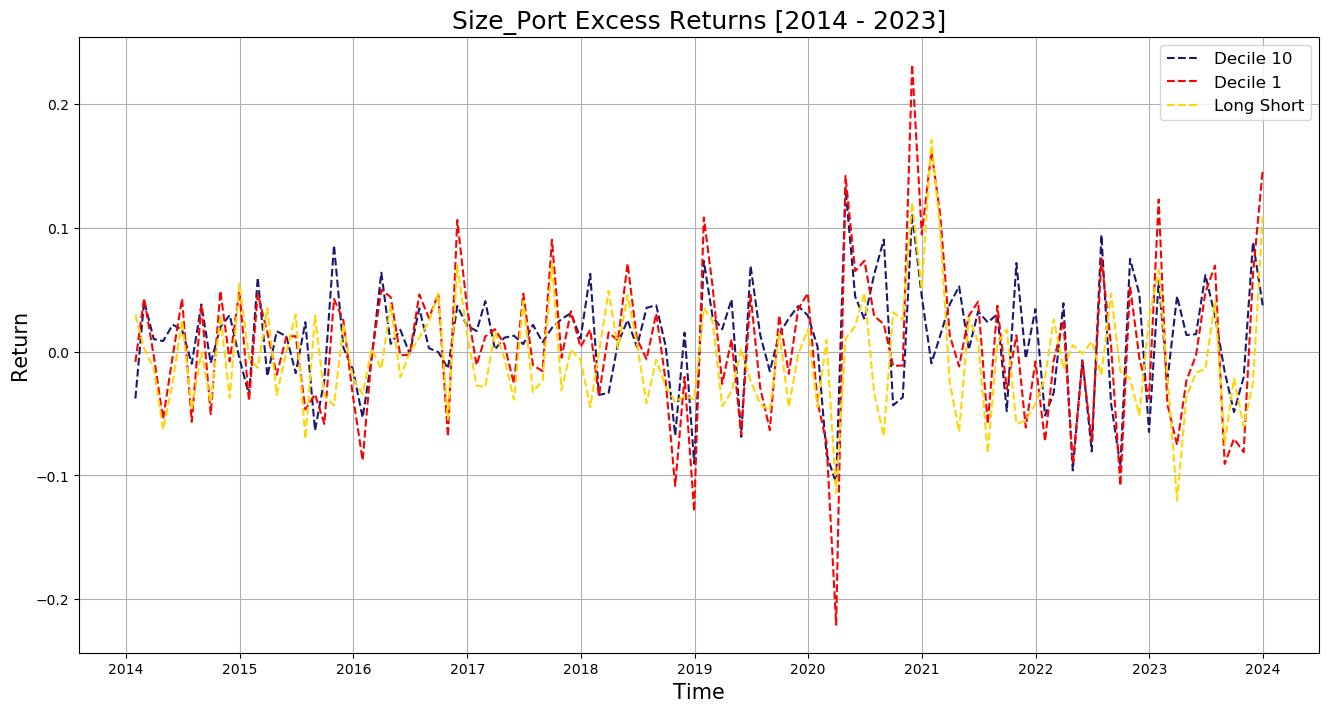

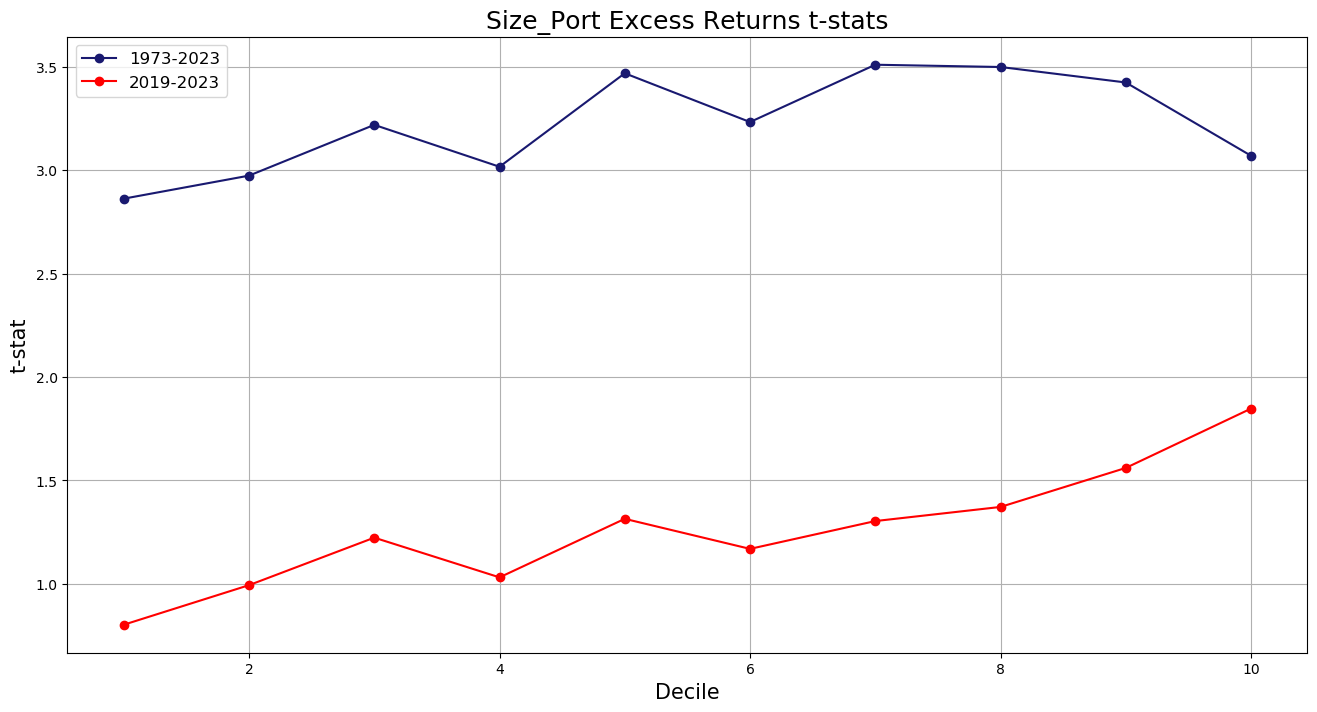

,1,2,3,4,5,6,7,8,9,10,Long_Short
Excess Return,8.2884,8.8943,9.3573,8.7141,9.2427,8.5431,8.8904,8.5396,8.0200,6.6700,1.6184
Volatility,21.7791,22.6060,21.3901,20.7259,20.2334,18.8379,18.7717,18.0197,16.6758,15.4032,16.2665
Sharpe Ratio,0.3806,0.3934,0.4375,0.4204,0.4568,0.4535,0.4736,0.4739,0.4809,0.4330,0.0995
Skewness,-0.1562,-0.2382,-0.4712,-0.5085,-0.4449,-0.5224,-0.4786,-0.4858,-0.4486,-0.3433,0.7977
Ex_Ret t-stat-all,2.7156,2.8075,3.1215,3.0001,3.2596,3.2361,3.3795,3.3816,3.4318,3.0899,0.7105
Ex_Ret t-stat-5yr,0.8052,1.0530,1.0061,1.0163,1.3057,1.1093,1.2772,1.3577,1.5444,1.8255,-0.6841


Size_Port,1,2,3,4,5,6,7,8,9,10,Long_Short
Excess Return,8.9281,9.5042,9.5550,8.7241,9.6553,8.4358,9.1040,8.7482,7.9486,6.6515,2.2766
Volatility,22.2751,22.8244,21.1970,20.6530,19.8796,18.6354,18.5237,17.8557,16.5781,15.4734,16.5330
Sharpe Ratio,0.4008,0.4164,0.4508,0.4224,0.4857,0.4527,0.4915,0.4899,0.4795,0.4299,0.1377
Skewness,-0.1366,-0.2041,-0.4748,-0.5199,-0.4556,-0.4955,-0.4965,-0.4711,-0.4208,-0.3347,0.8634
Ex_Ret t-stat-all,2.8624,2.9737,3.2192,3.0166,3.4685,3.2328,3.5099,3.4989,3.4241,3.0699,0.9826
Ex_Ret t-stat-5yr,0.8027,0.9940,1.2236,1.0317,1.3146,1.1694,1.3038,1.3721,1.5607,1.8475,-0.7148
corr w/ original,0.9963,0.9967,0.9968,0.9966,0.9959,0.9964,0.9961,0.9968,0.9976,0.9997,0.9928


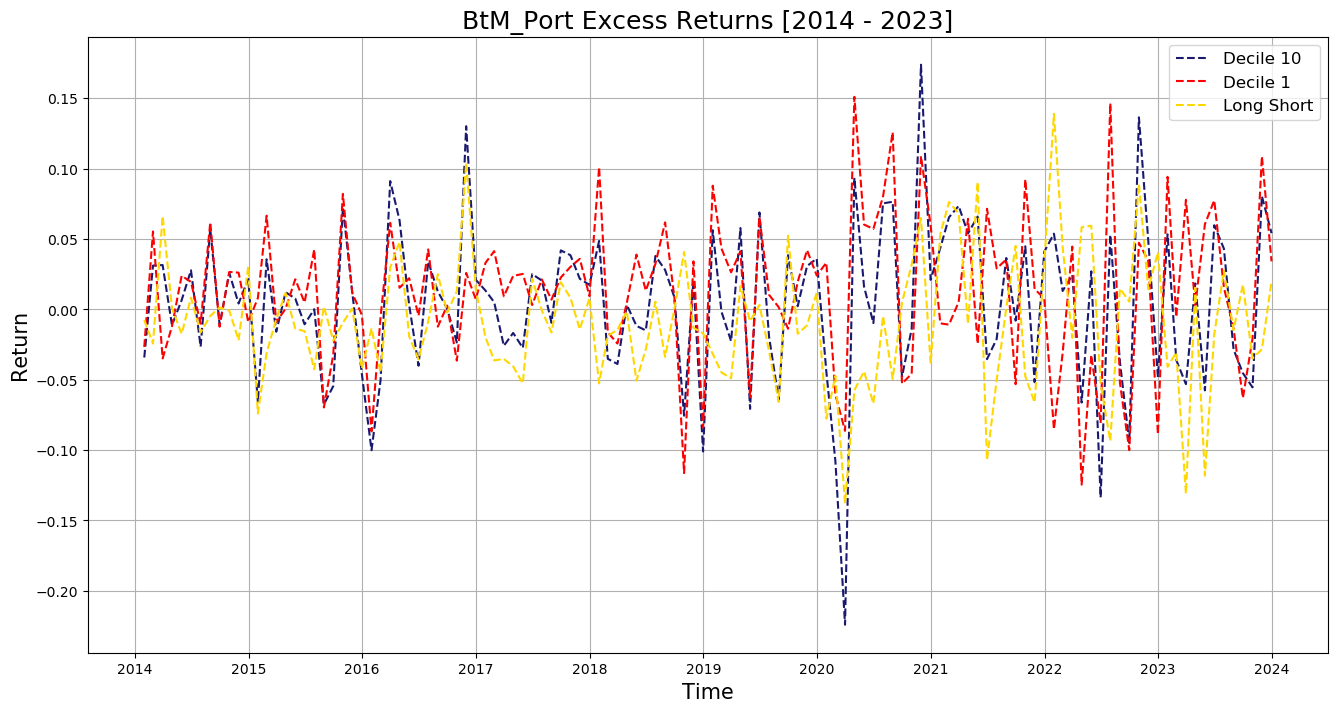

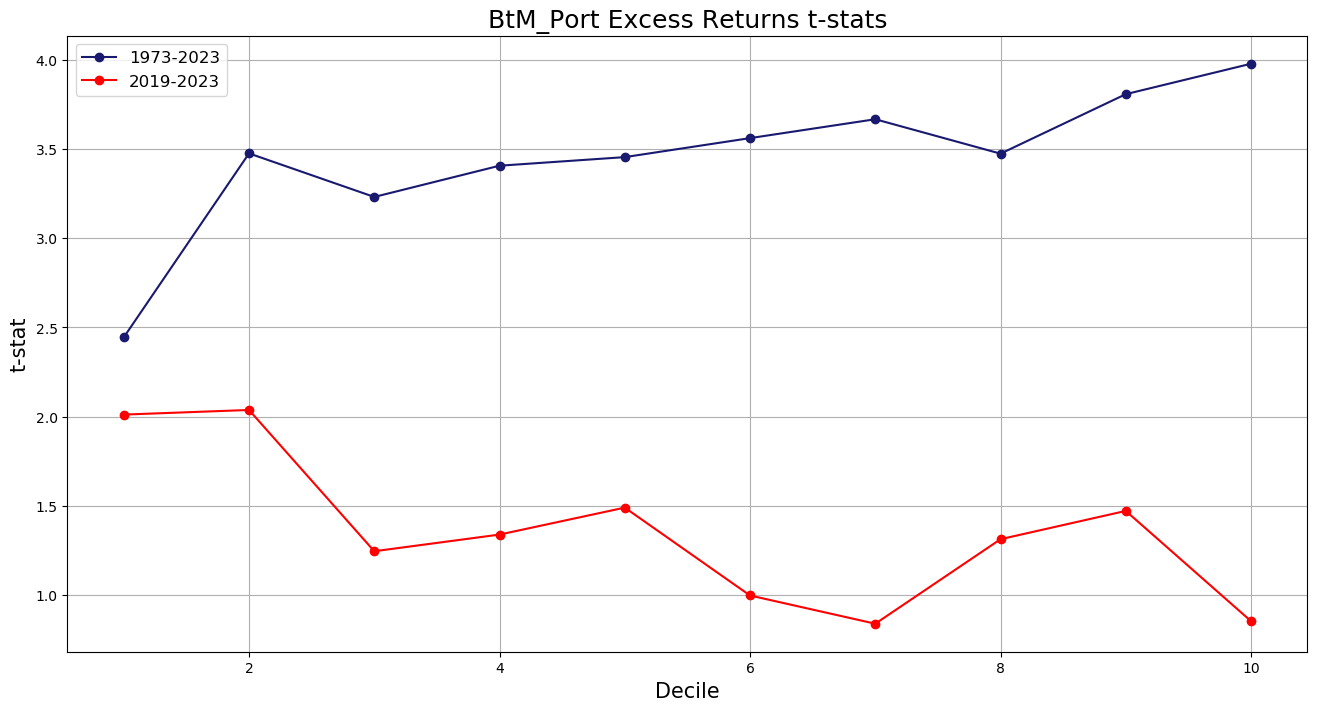

,1,2,3,4,5,6,7,8,9,10,Long_Short
Excess Return,6.2725,8.0135,7.9339,8.0518,7.6369,8.7555,7.1225,8.7261,10.7506,11.0806,4.8080
Volatility,18.2843,16.6775,16.3753,16.5587,15.7704,16.3435,16.6242,17.4091,18.3897,22.2132,17.5560
Sharpe Ratio,0.3431,0.4805,0.4845,0.4863,0.4843,0.5357,0.4284,0.5012,0.5846,0.4988,0.2739
Skewness,-0.2104,-0.4404,-0.5350,-0.4978,-0.4996,-0.4306,-0.4411,-0.6577,-0.3982,-0.4429,0.0486
Ex_Ret t-stat-all,2.4479,3.4287,3.4572,3.4697,3.4554,3.8226,3.0572,3.5766,4.1715,3.5594,1.9558
Ex_Ret t-stat-5yr,2.0062,1.9038,1.6792,1.2610,1.0743,1.4147,0.6646,1.4214,1.4520,0.9048,-0.5931


BtM_Port,1,2,3,4,5,6,7,8,9,10,Long_Short
Excess Return,6.3007,8.0743,7.3863,7.9663,7.9623,7.9923,8.5015,8.3559,9.4835,10.9077,4.6070
Volatility,18.4082,16.5933,16.3260,16.7029,16.4620,16.0300,16.5594,17.1792,17.7907,19.5846,15.8221
Sharpe Ratio,0.3423,0.4866,0.4524,0.4769,0.4837,0.4986,0.5134,0.4864,0.5331,0.5570,0.2912
Skewness,-0.2120,-0.4259,-0.5326,-0.5149,-0.5055,-0.4167,-0.3825,-0.5388,-0.4318,-0.2346,0.3419
Ex_Ret t-stat-all,2.4443,3.4750,3.2309,3.4060,3.4541,3.5606,3.6664,3.4736,3.8068,3.9774,2.0777
Ex_Ret t-stat-5yr,2.0116,2.0375,1.2459,1.3393,1.4903,0.9980,0.8398,1.3134,1.4719,0.8541,-1.2446
corr w/ original,0.9984,0.9902,0.9793,0.9812,0.9762,0.9741,0.9731,0.9618,0.9717,0.9595,0.9235


,HML,SMB
Excess Return,3.5816,1.7320
Volatility,10.8331,10.6027
Sharpe Ratio,0.3306,0.1634
Skewness,0.0676,0.4552
Ex_Ret t-stat-all,2.3611,1.1666
Ex_Ret t-stat-5yr,-0.0543,-0.1204


,HML,SMB
Excess Return,3.2233,1.8994
Volatility,10.8913,10.6421
Sharpe Ratio,0.2960,0.1785
Skewness,0.0523,0.5497
Ex_Ret t-stat-all,2.1135,1.2746
Ex_Ret t-stat-5yr,-0.1568,-0.1474
corr w/ original,0.9838,0.9954


In [17]:
# Runs all the functions and prints the required results
def driver(download_data=False, process_data=False, remerge=False):
    # Download the data only if needed
    if download_data == True:
        print("Downloading data ...")
        download_raw_crsp_data(data_dir, wrds_id)
        download_ff3_monthly_data(data_dir)
    else:
        print("Skipped data downloading!")
    
    # Process raw data only if needed
    if process_data == True:
        print("Processing raw data ...")
        process_raw_data()
    else:
        print("Skipped raw data processing!")
    
    # Link and Merge CRSP stock data with CompuStat data
    CRSP_Linked_Clean, CRSP_COMPU = link_n_merge_crsp_compu(remerge)

    # Defines size and book-to-market decile portfolios and book-to-market-LMH and size-SB portfolios    
    CRSP_PORT = define_portfolios(CRSP_Linked_Clean, CRSP_COMPU)

    # Load stored ffm returns as a dataframe
    ffm = pd.read_pickle(data_dir + 'ffm.pkl')
    
    # Compute returns for size and book-to-market decile portfolios and HML and SMB factors
    Size_Decile_Returns, BtM_Decile_Returns, CRSP_Factor_Returns = PS4_Q1(CRSP_PORT, ffm)    
    
    # Set display style
    sty = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "125%"), ("color", 'crimson')])]

    # Display Q2 results
    pd.set_option("display.precision", 4)
    ps4_q2, ps4_q2_auth = PS4_Q2(Size_Decile_Returns, ffm)
    display(ps4_q2_auth.style.set_caption("Size Decile Portfolios - 1973 to 2023 - Fama-French").set_table_styles(sty))
    #print(ps4_q2_auth)
    print("\n")
    display(ps4_q2.style.set_caption("Size Decile Portfolios - 1973 to 2023 - Replication").set_table_styles(sty))
    #print(ps4_q2)
    print("\n")
    
    # Display Q3 results
    ps4_q3, ps4_q3_auth = PS4_Q3(BtM_Decile_Returns, ffm)
    display(ps4_q3_auth.style.set_caption("BtM Decile Portfolios - 1973 to 2023 - Fama-French").set_table_styles(sty))
    #print(ps4_q3_auth)
    print("\n")
    display(ps4_q3.style.set_caption("BtM Decile Portfolios - 1973 to 2023 - Replication").set_table_styles(sty))
    #print(ps4_q3)
    print("\n")

    # Display Q5 results
    ps4_q5, ps4_q5_auth = PS4_Q5(CRSP_Factor_Returns, ffm)    
    display(ps4_q5_auth.style.set_caption("HML & SMB - 1973 to 2023 Fama-French").set_table_styles(sty))
    #print(ps4_q5_auth)
    print("\n")
    display(ps4_q5.style.set_caption("HML & SMB - 1973 to 2023 Replication").set_table_styles(sty))
    #print(ps4_q5)
    print("\n")

# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader
from pandas_datareader.famafrench import FamaFrenchReader as ffreader
import wrds
import os
from pandas.tseries.offsets import *
import datetime
from scipy.stats import ttest_1samp
from scipy.stats import skew
from scipy import stats
import math

# Directory to store the downloaded data
data_dir = 'data\\'

# WRDS login id
wrds_id = 'smarty_iitian'

# Filter relevant date - Reference - Assignment Instruction:
# "Output should be between January 1973 and December 2023"
min_year = 1973
max_year = 2023

# Specify whether we need to download the raw data or not
download_data = False

# Specify whether we need to process the raw data or not
process_data = False

# Specify whether we need to Link and Merge CRSP stock data with CompuStat data or not
remerge = False

driver(download_data, process_data, remerge)